In [5]:
import pandas as pd

# Data import
with pd.HDFStore('MiningProcess_Flotation_Plant_Database_train_split.h5') as store:
    X_cal = store.get('X_cal')
    Y_cal = store.get('Y_cal')
    X_test = store.get('X_test')
    Y_test = store.get('Y_test')


# TEMPLATE for model usage and calibration

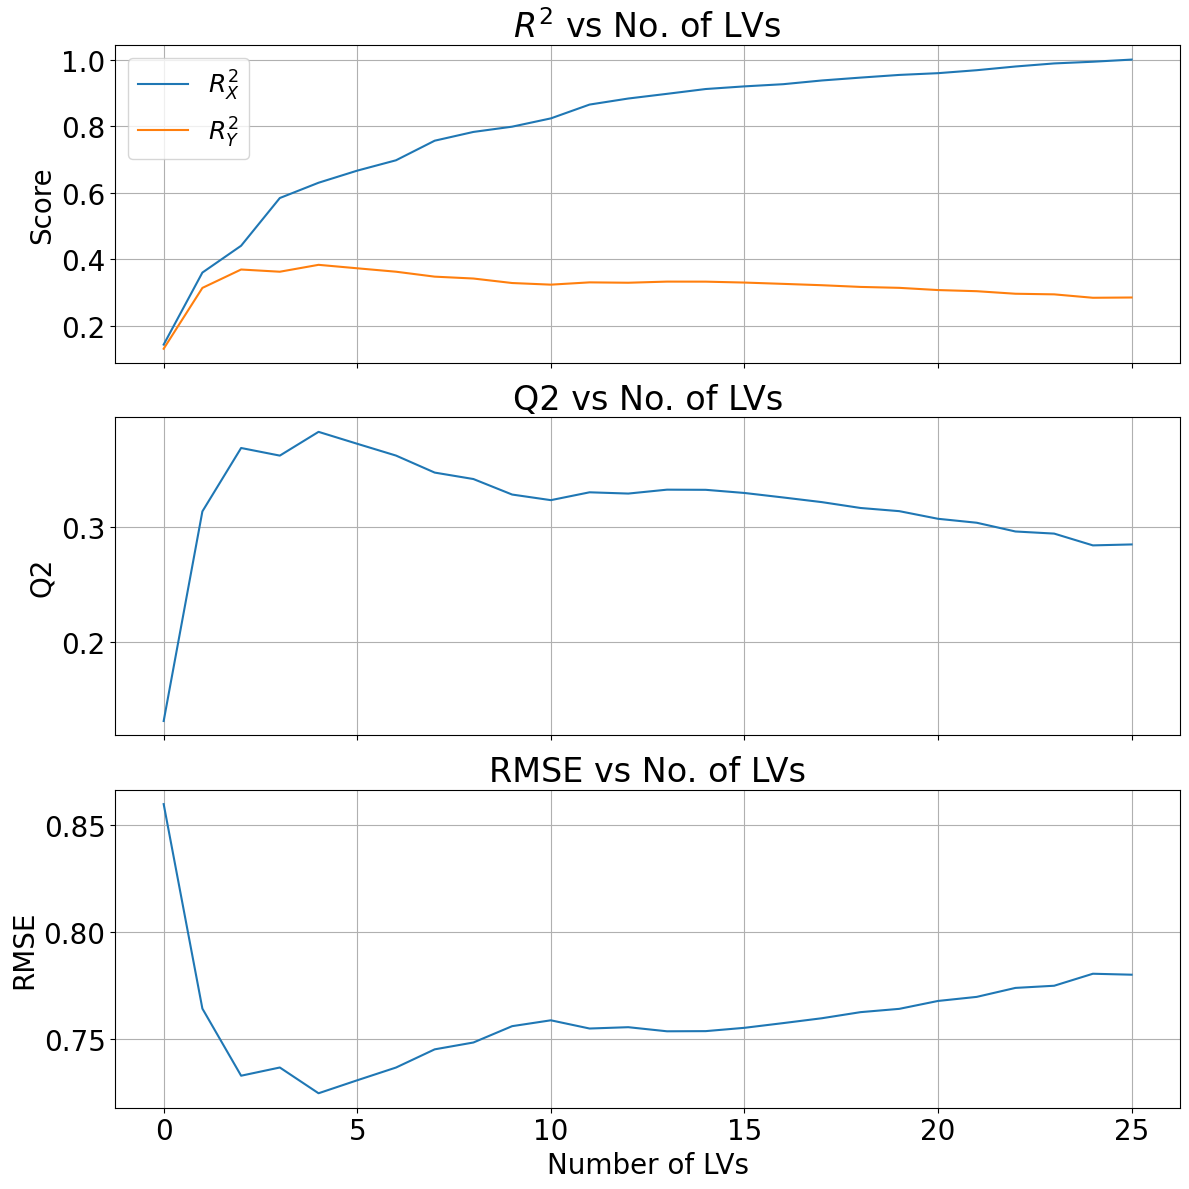

In [33]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import root_mean_squared_error, r2_score

n_features = X_test.shape[1]

def optimise_pls_cv(X, y, n_comp, n_splits=5):
    X = X.values
    y = y.values
    
    model = make_pipeline(StandardScaler(), PLSRegression(n_components=n_comp))
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    splits = tscv.split(X)

    start_index  = len(y) // n_splits
    
    y_cv = np.zeros( len(y) - start_index) 
    for fold_idx, (train_index, test_index) in enumerate( splits ):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model.fit(X_train, y_train)
        y_cv[ test_index - start_index ] = model.predict(X_test).flatten()
        
    
    y_calc = y[ start_index:]
    
    
    mse = root_mean_squared_error(y_calc, y_cv)  # RMSE
    
    tss = np.sum((y_calc - np.mean(y_calc)) ** 2)
    press = np.sum((y_calc - y_cv) ** 2)
    

    # Removing first fold from y_cv
    q2 = 1 - press / tss
    
    # Calculate R2X and R2Y
    model.fit(X, y)
    pls = model.named_steps['plsregression']
    X_scaled = model.named_steps['standardscaler'].transform(X)
    
    # R2X: Explained variance in X
    X_score = pls.x_scores_
    X_loadings = pls.x_loadings_
    X_reconstructed = np.dot(X_score, X_loadings.T)
    r2x = 1 - np.sum((X_scaled - X_reconstructed) ** 2) / np.sum(X_scaled ** 2)
    
    # R2Y: Explained variance in Y
    r2y = r2_score(y_calc, y_cv)
    
    return y_cv, q2, mse, r2x, r2y


n_splits = 3
y_cv, q2, mse, r2x, r2y = optimise_pls_cv(X_cal,Y_cal, 20, n_splits)


q2_scores = np.zeros(n_features)
mse_scores = np.zeros(n_features)
r2x_scores = np.zeros(n_features)
r2y_scores = np.zeros(n_features)
for ii in range(1, n_features+1 ):
    y_cv, q2, mse, r2x, r2y = optimise_pls_cv(X_cal,Y_cal, ii, n_splits)
    q2_scores[ii-1] = q2
    mse_scores[ii-1] = mse
    r2x_scores[ii-1] = r2x
    r2y_scores[ii-1] = r2y
    
    
    
TITLEFONT = 24
AXISFONT = 20
LEGENDFONT = 18

fig, axs = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
plt.rc('xtick', labelsize=AXISFONT)
plt.rc('ytick', labelsize=AXISFONT)

# First subplot: R2X and R2Y scores
axs[0].plot(r2x_scores)
axs[0].plot(r2y_scores)
axs[0].set_ylabel('Score', fontsize=AXISFONT)
axs[0].set_title(r'$R^2$ vs No. of LVs', fontsize=TITLEFONT)
axs[0].legend([r'$R^2_X$', r'$R^2_Y$'], fontsize=LEGENDFONT)
axs[0].grid(True)

# Second subplot: Q2 scores
axs[1].plot(q2_scores)
axs[1].set_ylabel('Q2', fontsize=AXISFONT)
axs[1].set_title('Q2 vs No. of LVs', fontsize=TITLEFONT)
axs[1].grid(True)

# Third subplot: MSE scores
axs[2].plot(mse_scores)
axs[2].set_xlabel('Number of LVs', fontsize=AXISFONT)
axs[2].set_ylabel('RMSE', fontsize=AXISFONT)
axs[2].set_title('RMSE vs No. of LVs', fontsize=TITLEFONT)
axs[2].grid(True)

# Adjust the layout and display the plot
plt.tight_layout()




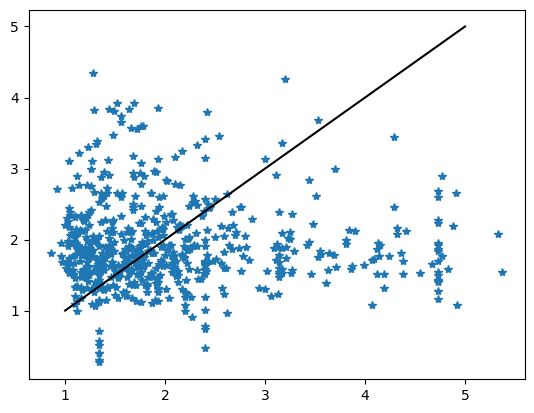

In [26]:

plt.plot(Y_cal[ 0:len(y_cv) ],y_cv,'*')
plt.plot([1,5],[1,5],'k')

# Template for testing

In [8]:
## After choosing No. LVs and variables
## X_cal should now only included wanted variables

n_comp = 7 # Replace with best value

scaler = StandardScaler()

X_cal_norm = scaler.fit_transform(X_cal) # this saves mean and std to scaler 

model = PLSRegression(n_components=n_comp)

model.fit(X_cal_norm,Y_cal) # Calculate pls model for calibration data

## predict

X_test_norm = scaler.transform(X_test) # this uses previously computed mean and std
Y_pred = model.predict(X_test_norm) # Calculate test data with precalculated model

# model parameters can be accessed for example
loadings = model.x_loadings_
